### Import Libraries & Define Utility Functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.metrics import classification_report, confusion_matrix

def show_confusion_matrix(confusion_matrix):
    """Adapted from Week 11 Live Session Notebook"""
    ax = plt.axes()
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='center')
    
    plt.ylabel('True Classification')
    plt.xlabel('Predicted Classification')
    
    plt.show()

### Load & pre-process Data Frame

In [2]:
import sys
sys.path.append("../data")

from process_data import process_data

X_train, y_train, X_test, y_test = process_data(buckets=10)

class_names = pd.concat([y_train['views_category_10'], y_test['views_category_10']]).unique().sort_values()

print("Before Cleanining")
X_train[['title','description']]

Before Cleanining


,title,description
2316,Filthiest Dunks in NBA History,The best dunks in NBA history. Let me know if ...
406,Rating EVERY American Cereal with Ludwig and A...,This will be the ultimate tier list of all the...
645,Easiest (and Hardest) Countries to Take Over,The world is filled with dominating military f...
1206,"$1 vs $1,000,000 Hotel Room!",The hotel at the end is worth the wait!\n\nDow...
592,Mayweather vs. Paul: Ceremonial Weigh-In | SHO...,Hall of Fame boxing legend Floyd Mayweather an...
...,...,...
1095,Elden Ring OFFICIAL DLC in Miquella's Dream Co...,The DLC is finally revealed! ELDEN RING: Shado...
1462,Kirby but tier list,Kirby Triple Deluxe but I finally have an opin...
2197,"LATEST! MARCH 18, 2023 PINOY boxer NO MERC...","LATEST! MARCH 18, 2023 PINOY boxer NO MERC..."
1039,As It Was - Harry Styles,🎶Lyrics:\nHoldin' me back\nGravity's holdin' m...


In [3]:
import nltk
from nltk.corpus import stopwords

def clean_text(text):
    """Function to clean up text by making all characters lowercase,
    removing non-alphanumeric characters, and removing common stop words"""

    # make the text lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub("https?[^\s]+", ' ', text)

    # remove non-alphabetic characters (including digits and punctuation)
    text = re.sub("[^a-zA-Z\s]", ' ', text)
    
    # remove single character words
    text = re.sub("\s[a-zA-Z]{1}\s", ' ', text)
    
    # remove excess white space
    text = re.sub("[ \t]{2,}", ' ', text)

    # remove common stop words
    stop_words = set(stopwords.words("english"))
    text = [w for w in text.split() if w not in stop_words]

    return " ".join(text)

X_train['description'] = X_train['description'].apply(clean_text)
X_test['description'] = X_test['description'].apply(clean_text)
X_train['title'] = X_train['title'].apply(clean_text)
X_test['title'] = X_test['title'].apply(clean_text)

print("After Cleaning")
X_train[['title','description']]

After Cleaning


,title,description
2316,filthiest dunks nba history,best dunks nba history let know make part than...
406,rating every american cereal ludwig abroad japan,ultimate tier list different cereal could find...
645,easiest hardest countries take,world filled dominating military forces around...
1206,vs hotel room,hotel end worth wait download experian app vis...
592,mayweather vs paul ceremonial weigh showtime ppv,hall fame boxing legend floyd mayweather socia...
...,...,...
1095,elden ring official dlc miquella dream confirm...,dlc finally revealed elden ring shadow erdtree...
1462,kirby tier list,kirby triple deluxe finally opinion thank note...
2197,latest march pinoy boxer mercy tinalo ang form...,latest march pinoy boxer mercy tinalo ang form...
1039,harry styles,lyrics holdin back gravity holdin back want ho...


### Classification Using Bag of Words Approach

Classify by Description
  1859 records containing 26640 unique words
              precision    recall  f1-score   support

           0       0.06      0.38      0.10         8
          10       0.20      0.19      0.20        47
          20       0.03      0.12      0.05        16
          30       0.25      0.08      0.12        99
          40       0.13      0.29      0.18        24
          50       0.26      0.10      0.15        87
          60       0.17      0.13      0.15        53
          70       0.02      0.06      0.03        16
          80       0.45      0.38      0.42        52
          90       0.58      0.46      0.51        63

    accuracy                           0.20       465
   macro avg       0.22      0.22      0.19       465
weighted avg       0.28      0.20      0.22       465



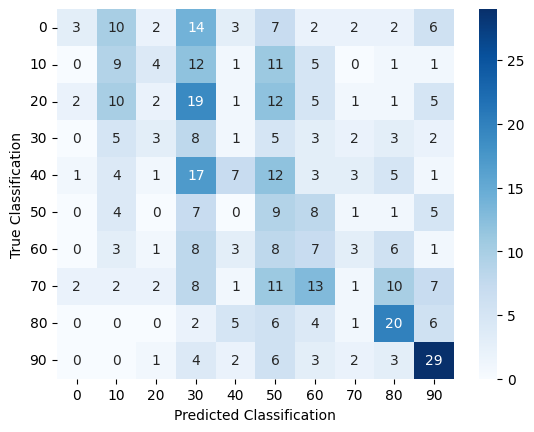


Classify by Title
  1859 records containing 12656 unique words
              precision    recall  f1-score   support

           0       0.40      0.12      0.18        51
          10       0.06      0.09      0.07        44
          20       0.18      0.05      0.08        58
          30       0.05      0.12      0.07        32
          40       0.13      0.04      0.06        54
          50       0.04      0.14      0.06        35
          60       0.09      0.10      0.10        40
          70       0.18      0.07      0.10        57
          80       0.08      0.07      0.07        44
          90       0.33      0.26      0.29        50

    accuracy                           0.10       465
   macro avg       0.15      0.11      0.11       465
weighted avg       0.17      0.10      0.11       465



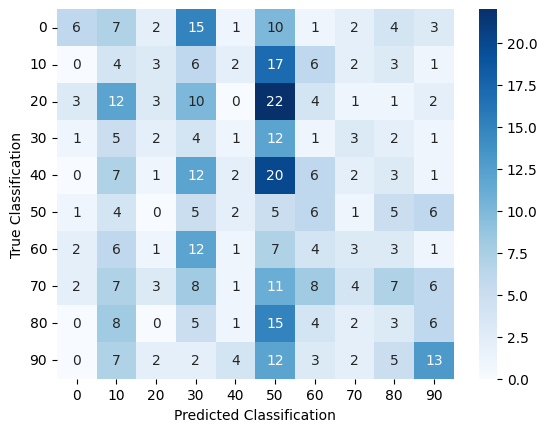

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


def classifyByText(X_train, Y_train, X_test, Y_test):
    count_vect = CountVectorizer()
    count_vect.fit(pd.concat([X_train, X_test]))
                   
    X_train_counts = count_vect.transform(X_train)

    print(f"  {X_train_counts.shape[0]:0d} records containing",
          f"{X_train_counts.shape[1]:0d} unique words")

    clf_MNB_pipe = Pipeline([("vect", CountVectorizer()), 
                             ("tfidf", TfidfTransformer()), 
                             ("clf_nominalNB", MultinomialNB())])
    clf_MNB_pipe.fit(X_train, Y_train)

    return clf_MNB_pipe.predict(X_test)

    
print("Classify by Description")
y_pred = classifyByText(X_train['description'], y_train['views_category_10'], 
                        X_test['description'], y_train['views_category_10'])
print(classification_report(y_pred, y_test['views_category_10']))

cm = confusion_matrix(y_test['views_category_10'], y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

print("")

print("Classify by Title")
y_pred = classifyByText(X_train['title'], y_train['views_category_10'], 
                        X_test['description'], y_train['views_category_10'])
print(classification_report(y_true=y_test['views_category_10'],
                            y_pred=y_pred))

cm = confusion_matrix(y_true=y_test['views_category_10'], 
                      y_pred=y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Classification Using Embeddings

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def classifyByTextEmbeddings(X_train, Y_train, X_test, Y_test,
                             vocab_size=5000, sequence_len=100,
                             embedding_dim=2, num_epochs=5, 
                             verbose=1, make_predictions=0):

    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(pd.concat([X_train, X_test]))

    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_train_padded_seq = pad_sequences(X_train_seq, 
                                       maxlen=sequence_len, 
                                       padding='post', 
                                       truncating='post')

    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        input_length=sequence_len))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=8, activation="relu"))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy'])
    
    print("")
    model.summary()

    print("")
    print("Model Hyperparameters")
    print("---------------------")
    print("Vocabulary Size:", vocab_size)
    print("Sequence Length:", sequence_len)
    print("Embedding Dimensions:", embedding_dim)
    print("Number of Epochs:", num_epochs)
    print("")
    
    history = model.fit(
        x=X_train_padded_seq,
        y=Y_train,
        epochs=num_epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=verbose
    )
    
    history = pd.DataFrame(history.history)

    if verbose == 1:
        print("")
        
    print(f"---> Train Loss: {history['loss'][num_epochs-1]:0.4f} Accuracy: {history['sparse_categorical_accuracy'][num_epochs - 1]:0.4f}")
    print(f"---> Val   Loss: {history['val_loss'][num_epochs-1]:0.4f} Accuracy: {history['val_sparse_categorical_accuracy'][num_epochs - 1]:0.4f}")
    
    if make_predictions == 1:
        X_test_seq = tokenizer.texts_to_sequences(X_test)
        X_test_padded_seq = pad_sequences(X_test_seq, 
                                          maxlen=sequence_len, 
                                          padding='post', 
                                          truncating='post')

        metrics = model.evaluate(
                      x=X_test_padded_seq,
                      y=Y_test,
                      return_dict=True
                  )
    
        return model.predict(x=X_test_padded_seq)
    else:
        return None

#### Encode output categories to use with model

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(pd.concat([y_train['views_category_10'], y_test['views_category_10']]))

Y_train_cat = encoder.transform(y_train['views_category_10'])
Y_test_cat = encoder.transform(y_test['views_category_10'])

class_names = np.unique(np.concatenate((Y_train_cat, Y_test_cat)))
class_names.sort()

print("Class Names:", class_names)

Class Names: [0 1 2 3 4 5 6 7 8 9]


#### Run model on video descriptions with different hyperparameter values to determine most accurate model

In [7]:
classifyByTextEmbeddings(X_train=X_train['description'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['description'],
                         Y_test=Y_test_cat,
                         vocab_size=1000, sequence_len=50,
                         embedding_dim=8, num_epochs=5, 
                         verbose=0, make_predictions=0)

classifyByTextEmbeddings(X_train=X_train['description'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['description'],
                         Y_test=Y_test_cat,
                         vocab_size=1000, sequence_len=100,
                         embedding_dim=16, num_epochs=10,
                         verbose=0, make_predictions=0)

classifyByTextEmbeddings(X_train=X_train['description'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['description'],
                         Y_test=Y_test_cat,
                         vocab_size=2000, sequence_len=100,
                         embedding_dim=32, num_epochs=10,
                         verbose=0, make_predictions=0)

classifyByTextEmbeddings(X_train=X_train['description'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['description'],
                         Y_test=Y_test_cat,
                         vocab_size=2500, sequence_len=150,
                         embedding_dim=32, num_epochs=10,
                         verbose=0, make_predictions=0)

classifyByTextEmbeddings(X_train=X_train['description'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['description'],
                         Y_test=Y_test_cat,
                         vocab_size=5000, sequence_len=300,
                         embedding_dim=64, num_epochs=20,
                         verbose=0, make_predictions=0)

Metal device set to: Apple M2 Pro

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 8)             8000      
                                                                 
 conv1d (Conv1D)             (None, 43, 16)            1040      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
Total params: 9,210
Trainable params: 9,210
Non-trainable params: 0
_________________________________________________________________

Model Hyperparameters
---------------------
Vocabulary Size: 1000
Sequence Length: 5

#### Summary of Model Metrics with Different Hyperparameters

|Vocab Size|Sequence Len|Embedding Dims|# of Epochs|Train Loss|Train Accuracy|Val Loss|Val Accuracy|
|:--------:|:----------:|:------------:|:---------:|---------:|-------------:|-------:|-----------:|
|1000|50|8|5|2.2760|0.1494|2.2834|0.1344|
|1000|100|16|10|2.1693|0.2516|2.2184|0.1989|
|2000|100|32|10|1.9823|0.3640|2.1688|0.1667|
|2500|150|32|10|2.0003|0.3670|2.1742|0.2419|
|5000|300|64|20|1.1988|0.6754|2.3267|0.3118|


#### Re-run Model with Best Hyperparameters and Make Predictions


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           16000     
                                                                 
 conv1d (Conv1D)             (None, 93, 16)            2064      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
Total params: 18,234
Trainable params: 18,234
Non-trainable params: 0
_________________________________________________________________

Model Hyperparameters
---------------------
Vocabulary Size: 1000
Sequence Length: 100
Embedding Dimensions: 16
Numb

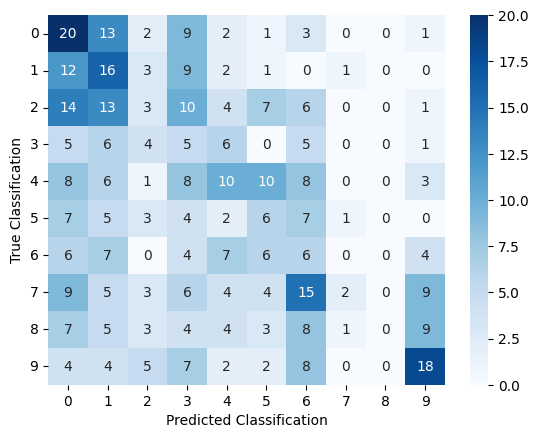

In [8]:
Y_pred = classifyByTextEmbeddings(X_train=X_train['description'], 
                                  Y_train=Y_train_cat,
                                  X_test=X_test['description'],
                                  Y_test=Y_test_cat,
                                  vocab_size=1000, sequence_len=100,
                                  embedding_dim=16, num_epochs=10, 
                                  verbose=1, make_predictions=1)

Y_pred_cat = [np.argmax(x) for x in Y_pred]
print(classification_report(y_true=Y_test_cat, y_pred=Y_pred_cat))

cm = confusion_matrix(y_true=Y_test_cat, y_pred=Y_pred_cat)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

#### Run model on video titles with different hyperparameter values to determine most accurate model

In [9]:
classifyByTextEmbeddings(X_train=X_train['title'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['title'],
                         Y_test=Y_test_cat,
                         vocab_size=500, sequence_len=12,
                         embedding_dim=4, num_epochs=5, 
                         verbose=0, make_predictions=0)

classifyByTextEmbeddings(X_train=X_train['title'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['title'],
                         Y_test=Y_test_cat,
                         vocab_size=1000, sequence_len=12,
                         embedding_dim=4, num_epochs=10,
                         verbose=0, make_predictions=0)

classifyByTextEmbeddings(X_train=X_train['title'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['title'],
                         Y_test=Y_test_cat,
                         vocab_size=1000, sequence_len=24,
                         embedding_dim=4, num_epochs=10,
                         verbose=0, make_predictions=0)

classifyByTextEmbeddings(X_train=X_train['title'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['title'],
                         Y_test=Y_test_cat,
                         vocab_size=2000, sequence_len=24,
                         embedding_dim=8, num_epochs=10,
                         verbose=0, make_predictions=0)

classifyByTextEmbeddings(X_train=X_train['title'], 
                         Y_train=Y_train_cat,
                         X_test=X_test['title'],
                         Y_test=Y_test_cat,
                         vocab_size=2000, sequence_len=32,
                         embedding_dim=8, num_epochs=10,
                         verbose=0, make_predictions=0)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 4)             2000      
                                                                 
 conv1d (Conv1D)             (None, 5, 16)             528       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
_________________________________________________________________

Model Hyperparameters
---------------------
Vocabulary Size: 500
Sequence Length: 12
Embedding Dimensions: 4
Number of

#### Summary of Model Metrics with Different Hyperparameters

|Vocab Size|Sequence Len|Embedding Dims|# of Epochs|Train Loss|Train Accuracy|Val Loss|Val Accuracy|
|:--------:|:----------:|:------------:|:---------:|---------:|-------------:|-------:|-----------:|
|500|12|4|5|2.2913|0.1524|2.3002|0.1075|
|1000|12|4|10|2.2059|0.2343|2.2781|0.1344|
|1000|24|4|10|2.2675|0.1620|2.2961|0.1290|
|2000|24|8|10|2.1992|0.2140|2.2769|0.1398|
|2000|32|8|10|2.2401|0.1841|2.2881|0.1290|


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 4)             4000      
                                                                 
 conv1d (Conv1D)             (None, 17, 16)            528       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
Total params: 4,698
Trainable params: 4,698
Non-trainable params: 0
_________________________________________________________________

Model Hyperparameters
---------------------
Vocabulary Size: 1000
Sequence Length: 24
Embedding Dimensions: 4
Number o

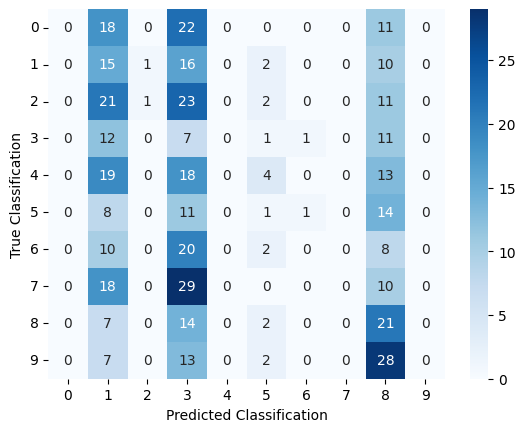

In [10]:
Y_pred = classifyByTextEmbeddings(X_train=X_train['title'], 
                                  Y_train=Y_train_cat,
                                  X_test=X_test['title'],
                                  Y_test=Y_test_cat,
                                  vocab_size=1000, sequence_len=24,
                                  embedding_dim=4, num_epochs=10,
                                  verbose=1, make_predictions=1)

Y_pred_cat = [np.argmax(x) for x in Y_pred]
print(classification_report(y_true=Y_test_cat, y_pred=Y_pred_cat))

cm = confusion_matrix(y_true=Y_test_cat, y_pred=Y_pred_cat)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Classification using Transformers

In [11]:
import torch
import torch.nn as nn

from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup

from collections import defaultdict
from transformers_util import TextDataset, ViewCategoryClassifier, create_data_loader
from transformers_util import train_epoch, eval_model, get_predictions

from sklearn.model_selection import train_test_split

"""Code adapted from W207 Week 13 Session Notebook on Sentiment Analysis using Transformers"""

PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
BATCH_SIZE = 32
EPOCHS = 10

def run_experiment(X_train, train_data_loader, X_val, val_data_loader, X_test, test_data_loader):
    """Given a training, validation, and test dataset, train a transformer model using the training
    dataset, evaluate the model's accuracy against the validation dataset after each EPOCH,
    make predictions using the test dataset and evaluate the model's accuracy"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = ViewCategoryClassifier(len(class_names), PRE_TRAINED_MODEL_NAME)
    model = model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(X_train)
        )
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn,
            device,
            len(X_val)
        )
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    y_text_texts, y_pred, y_pred_probs, y_test = get_predictions(
        model,
        test_data_loader,
        device
    )

    print(classification_report(y_true=y_test.numpy(), y_pred=y_pred.numpy()))

    cm = confusion_matrix(y_true=y_test.numpy(), 
                          y_pred=y_pred.numpy())
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    show_confusion_matrix(df_cm)

#### Train and test model using YouTube video descriptions

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------
Train loss 2.300763049215641 accuracy 0.10161386730424388
Val   loss 2.2952957153320312 accuracy 0.11827956989247312

Epoch 2/10
----------
Train loss 2.299047312646542 accuracy 0.10101613867304243
Val   loss 2.292852799097697 accuracy 0.11827956989247312

Epoch 3/10
----------
Train loss 2.29187932554281 accuracy 0.12731619844590555
Val   loss 2.2917813857396445 accuracy 0.11290322580645161

Epoch 4/10
----------
Train loss 2.285081921883349 accuracy 0.12731619844590555
Val   loss 2.291130463282267 accuracy 0.10752688172043011

Epoch 5/10
----------
Train loss 2.278788076256806 accuracy 0.12492528392109982
Val   loss 2.285402536392212 accuracy 0.14516129032258066

Epoch 6/10
----------
Train loss 2.27168792148806 accuracy 0.14823670053795576
Val   loss 2.283216436704 accuracy 0.14516129032258066

Epoch 7/10
----------
Train loss 2.2564043863764347 accuracy 0.1835026897788404
Val   loss 2.2610402504603067 accuracy 0.16666666666666666

Epoch 8/10
----------
Train l

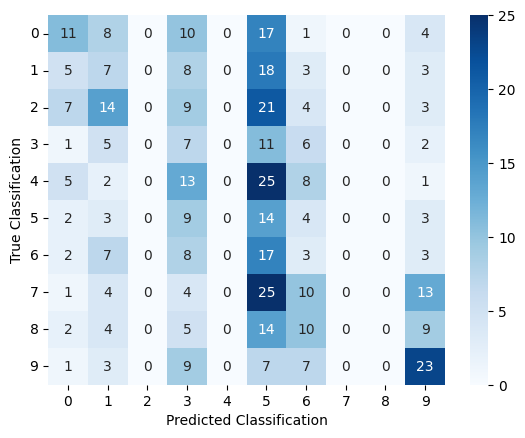

In [12]:
# create a validation dataset from our training data set
X_train_1, X_val, Y_train_cat_1, Y_val_cat = train_test_split(X_train, Y_train_cat, test_size=0.1, shuffle=True)

MAX_LEN = 100

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(X_train_1['description'], Y_train_cat_1, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(X_val['description'], Y_val_cat, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test['description'], Y_test_cat, tokenizer, MAX_LEN, BATCH_SIZE)

run_experiment(X_train_1, train_data_loader, X_val, val_data_loader, X_test, test_data_loader)

#### Train and test model with YouTube video titles

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------
Train loss 2.303424061469312 accuracy 0.0986252241482367
Val   loss 2.3056016763051352 accuracy 0.0913978494623656

Epoch 2/10
----------
Train loss 2.303423877032298 accuracy 0.10699342498505679
Val   loss 2.3040013710657754 accuracy 0.0967741935483871

Epoch 3/10
----------
Train loss 2.304118624273336 accuracy 0.09444112372982666
Val   loss 2.3036490281422934 accuracy 0.0967741935483871

Epoch 4/10
----------
Train loss 2.3017129043363176 accuracy 0.10460251046025104
Val   loss 2.3041388988494873 accuracy 0.0967741935483871

Epoch 5/10
----------
Train loss 2.292185131108986 accuracy 0.127913927077107
Val   loss 2.3032829761505127 accuracy 0.0913978494623656

Epoch 6/10
----------
Train loss 2.275681090804766 accuracy 0.1506276150627615
Val   loss 2.299134135246277 accuracy 0.11827956989247312

Epoch 7/10
----------
Train loss 2.2486975642870055 accuracy 0.19964136282127914
Val   loss 2.303505460421244 accuracy 0.0913978494623656

Epoch 8/10
----------
Train lo

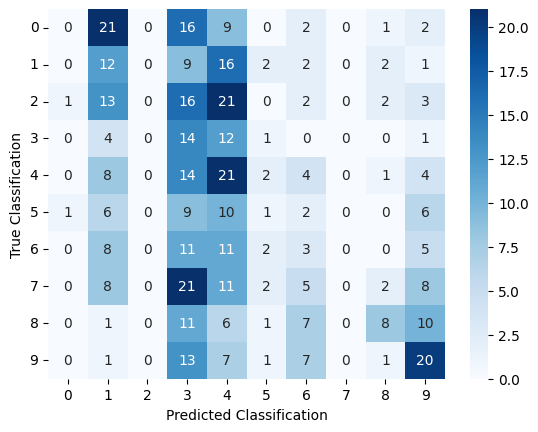

In [13]:
MAX_LEN = 24

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(X_train_1['title'], Y_train_cat_1, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(X_val['title'], Y_val_cat, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test['title'], Y_test_cat, tokenizer, MAX_LEN, BATCH_SIZE)

run_experiment(X_train_1, train_data_loader, X_val, val_data_loader, X_test, test_data_loader)